In [105]:
import random
import json
import re
import os

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent


# Experiment - Gemma3 4b it-qat

Analysis on the performance of Gemma3 4b instruction tuned quantization aware training on the scene graphs generated by the VLM.

**Parameters:**
- model: Gemma3 4b instruction-tuned quantization-aware-training
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


## Prompts

In [106]:
with open(WORK_DIR / 'data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [107]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt", 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives. Think step by step.



In [108]:
with open(WORK_DIR / "data/prompts/zero-shot-cot/auto_reply_ZS_CoT.txt", 'r') as f:
    reply = f.read()

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\



Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [109]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [110]:
predictions = []
with open(WORK_DIR / 'outputs/responses_to_genframes_gemma3:4b_it_qat_20250526_21:42:99.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_43,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1104,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1263,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1267,"[{'role': 'user', 'content': 'Please carefully..."


In [111]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_43,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1104,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1263,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1267,"[{'role': 'user', 'content': 'Please carefully..."


In [112]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [113]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_14      ```json\n{\n  "answer": "B. The table."\n}\n```
Interaction_T1_31            ```json\n{"answer": "A. The pillow"}\n```
Interaction_T1_32     ```json\n{\n  "answer": "C. The blanket"\n}\n```
Interaction_T1_40    ```json\n{\n  "answer": "B. The closet/cabinet...
Interaction_T1_43        ```json\n{\n  "answer": "A. The box."\n}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [114]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 1694
Answers following JSON template: 1694
Percentage following JSON template: 100.00%


In [115]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [116]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_14                      {\n  "answer": "B. The table."\n}
Interaction_T1_31                            {"answer": "A. The pillow"}
Interaction_T1_32                     {\n  "answer": "C. The blanket"\n}
Interaction_T1_40             {\n  "answer": "B. The closet/cabinet."\n}
Interaction_T1_43                        {\n  "answer": "A. The box."\n}
                                             ...                        
Feasibility_T6_1104             {\n  "answer": "C. Sit on the floor."\n}
Feasibility_T6_1263    {\n  "answer": "None of the alternatives are c...
Feasibility_T6_1267    {\n  "answer": "B. Put down the paper/notebook...
Feasibility_T6_1326            {\n  "answer": "C. Put down the shoe."\n}
Feasibility_T6_1453                 {\n  "answer": "D. Open the bag."\n}
Name: answer, Length: 1694, dtype: object

### The need to replace single quotes

In [117]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

In [118]:
el = predictions_df.loc['Interaction_T3_3111']
el


chat_history    [{'role': 'user', 'content': 'Please carefully...
answer                      {\n  "answer": "C. Took the towel"\n}
Name: Interaction_T3_3111, dtype: object

In [119]:
re.findall('[\u2018-\u201b]', el['answer'])


[]

In [120]:
re.findall('[\u201c-\u201d]', el['answer'])


[]

In [121]:
import unicodedata

def print_unicode_codes(s):
    print("Char | Unicode Point | UTF-8 Bytes | Name")
    print("-" * 50)
    for char in s:
        code = ord(char)
        utf8_bytes = list(char.encode('utf-8'))
        try:
            name = unicodedata.name(char)
        except ValueError:
            name = "No name"
        print(f"'{char}'  | U+{code:04X}       | {utf8_bytes}      | {name}")

# Requires: import unicodedata
print_unicode_codes(el['answer'])


Char | Unicode Point | UTF-8 Bytes | Name
--------------------------------------------------
'{'  | U+007B       | [123]      | LEFT CURLY BRACKET
'
'  | U+000A       | [10]      | No name
' '  | U+0020       | [32]      | SPACE
' '  | U+0020       | [32]      | SPACE
'"'  | U+0022       | [34]      | QUOTATION MARK
'a'  | U+0061       | [97]      | LATIN SMALL LETTER A
'n'  | U+006E       | [110]      | LATIN SMALL LETTER N
's'  | U+0073       | [115]      | LATIN SMALL LETTER S
'w'  | U+0077       | [119]      | LATIN SMALL LETTER W
'e'  | U+0065       | [101]      | LATIN SMALL LETTER E
'r'  | U+0072       | [114]      | LATIN SMALL LETTER R
'"'  | U+0022       | [34]      | QUOTATION MARK
':'  | U+003A       | [58]      | COLON
' '  | U+0020       | [32]      | SPACE
'"'  | U+0022       | [34]      | QUOTATION MARK
'C'  | U+0043       | [67]      | LATIN CAPITAL LETTER C
'.'  | U+002E       | [46]      | FULL STOP
' '  | U+0020       | [32]      | SPACE
'T'  | U+0054       | [84]  

In [122]:
import tokenize
from io import StringIO
import ast

def debug_parsing(code):
    try:
        # First try full parse
        ast.parse(code)
    except SyntaxError as e:
        print(f"Full parse failed at line {e.lineno}")
        print("Token stream up to error:")
        
        # Show token stream
        tokens = tokenize.generate_tokens(StringIO(code).readline)
        for tok in tokens:
            print(f"{tokenize.tok_name[tok.type]:<15} {tok.string!r:<20} {tok.start}->{tok.end}")
            if tok.start[0] > e.lineno or (
                tok.start[0] == e.lineno and tok.start[1] >= e.offset
            ):
                print("-- Error occurs here --")
                break

debug_parsing(el['answer'])


### Applying changes

In [123]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [124]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",B. The table.
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",A. The pillow
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",C. The blanket
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",B. The closet/cabinet.
Interaction_T1_43,"[{'role': 'user', 'content': 'Please carefully...",A. The box.
...,...,...
Feasibility_T6_1104,"[{'role': 'user', 'content': 'Please carefully...",C. Sit on the floor.
Feasibility_T6_1263,"[{'role': 'user', 'content': 'Please carefully...",None of the alternatives are correct. The most...
Feasibility_T6_1267,"[{'role': 'user', 'content': 'Please carefully...",B. Put down the paper/notebook.


In [125]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 1386
81.82% of the total

Only 308 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_445971/3127831504.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [126]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_70      None of the alternatives are directly supporte...
Interaction_T1_76                                                   None
Interaction_T1_294     None of the alternatives are present in the sc...
Interaction_T1_376                 None of the alternatives are correct.
Interaction_T1_426                      None of the objects were washed.
                                             ...                        
Feasibility_T5_438     The question cannot be answered with certainty...
Feasibility_T5_1874    None of the alternatives are correct based on ...
Feasibility_T6_700                 None of the alternatives are correct.
Feasibility_T6_706     None of the alternatives are supported by the ...
Feasibility_T6_1263    None of the alternatives are correct. The most...
Name: answer, Length: 308, dtype: object

## Extract answers

In [127]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_gen_stsg_df = ans_df
ans_gen_stsg_df


,text
id,
Interaction_T1_14,the table.
Interaction_T1_31,the pillow.
Interaction_T1_32,the blanket.
Interaction_T1_40,the closet/cabinet.
Interaction_T1_43,the box.
...,...
Feasibility_T6_978,sit on the bed.
Feasibility_T6_1104,sit on the floor.
Feasibility_T6_1267,put down the paper/notebook.


In [128]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1386 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1386 non-null   object
dtypes: object(1)
memory usage: 21.7+ KB


In [129]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 262 unique answers


In [130]:
ans_df['text'].value_counts()


text
took.                 138
put down.             100
the laptop.            61
the clothes.           57
opened.                53
                     ... 
throw the pillow.       1
sit on the bed.         1
sit on the floor.       1
put down the shoe.      1
open the bag.           1
Name: count, Length: 131, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

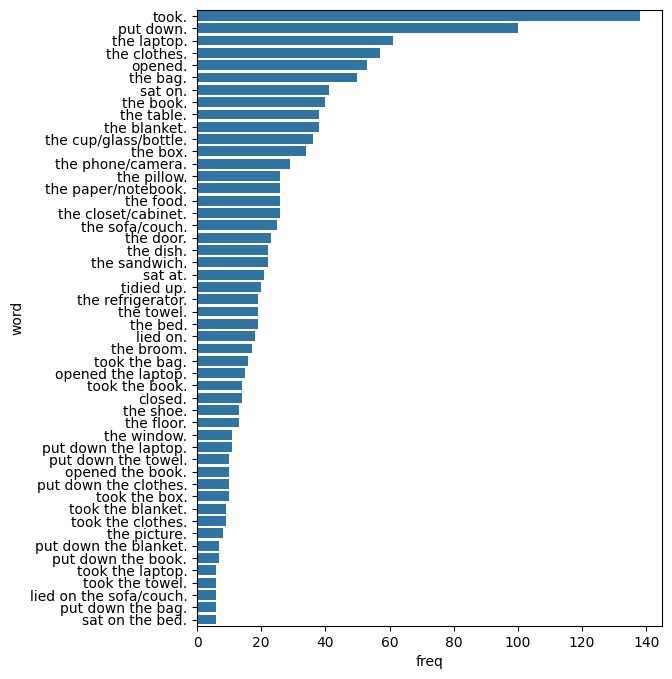

In [131]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [132]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<Axes: xlabel='freq', ylabel='word'>

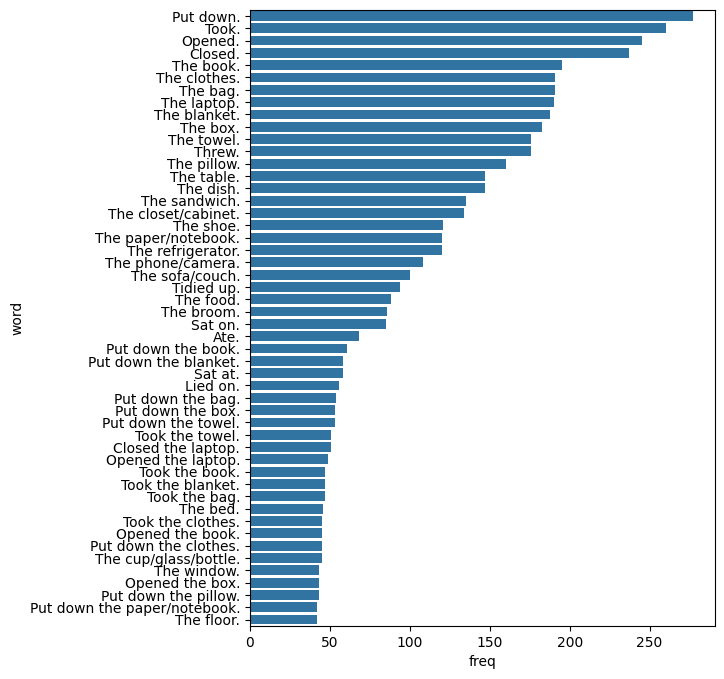

In [133]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [134]:
# Inner join - keeps only indices present in both series

ans_df_tmp = ans_df.rename(columns={'text': 'pred_text'})
eval_df = gt_df.join(
    ans_df_tmp, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(1386, 5)

In [135]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [136]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [137]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1322        43.12%  
Sequence              6         66.67%  
Prediction            0          nan%   
Feasibility          58         39.66%  


/tmp/ipykernel_445971/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


In [138]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        55.13%  
Sequence            3586        0.17%   
Prediction           624        0.00%   
Feasibility          490        11.84%  
Overall             7098        19.53%  


## Loading predicted answers - ground truth stsg as input

In [139]:
predictions = []
with open(WORK_DIR / 'outputs/responses_gemma3:4b_20250323_20:38:00.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df



,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': ""Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': ""Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': ""Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': ""Please carefully..."


In [140]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully..."
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully..."
...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully..."
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully..."


In [141]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [142]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T1_13     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_14    ```json\n{"answer": "C. The clothes."}\n```
Interaction_T1_31     ```json\n{"answer": "C. The clothes"}\n```
Interaction_T1_32       ```json\n{"answer": "B. The shoe."}\n```
Interaction_T1_40    ```json\n{"answer": "C. The blanket."}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [143]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 7098
Answers following JSON template: 7097
Percentage following JSON template: 99.99%


In [144]:
predictions_df.loc[~json_mask, 'answer']


id
Prediction_T4_1351    ```json\n{"answer": "Therefore the final answe...
Name: answer, dtype: object

In [145]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T1_13          {"answer": "C. The clothes"}
Interaction_T1_14         {"answer": "C. The clothes."}
Interaction_T1_31          {"answer": "C. The clothes"}
Interaction_T1_32            {"answer": "B. The shoe."}
Interaction_T1_40         {"answer": "C. The blanket."}
                                     ...               
Feasibility_T6_1453    {"answer": "A. Wash the table."}
Feasibility_T6_1454     {"answer": "A. Take the towel"}
Feasibility_T6_1455    {"answer": "B. Wash the table."}
Feasibility_T6_1456    {"answer": "D. Wash the table."}
Feasibility_T6_1468      {"answer": "B. Hold the food"}
Name: answer, Length: 7098, dtype: object

### Applying changes

In [146]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [147]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T1_13,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes
Interaction_T1_14,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes.
Interaction_T1_31,"[{'role': 'user', 'content': 'Please carefully...",C. The clothes
Interaction_T1_32,"[{'role': 'user', 'content': 'Please carefully...",B. The shoe.
Interaction_T1_40,"[{'role': 'user', 'content': 'Please carefully...",C. The blanket.
...,...,...
Feasibility_T6_1453,"[{'role': 'user', 'content': 'Please carefully...",A. Wash the table.
Feasibility_T6_1454,"[{'role': 'user', 'content': 'Please carefully...",A. Take the towel
Feasibility_T6_1455,"[{'role': 'user', 'content': 'Please carefully...",B. Wash the table.


In [148]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do NOT contain the answer in the response with the specified format")


Answer following the template: 6778
95.49% of the total

Only 320 samples do NOT contain the answer in the response with the specified format


/tmp/ipykernel_445971/1875602683.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [149]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T1_198     None of the alternatives are correct based on ...
Interaction_T1_1255                None of the alternatives are correct.
Interaction_T1_1369                None of the alternatives are correct.
Interaction_T1_1671    None of the alternatives can be determined fro...
Interaction_T1_2509    None of the alternatives are correct based on ...
                                             ...                        
Feasibility_T6_448                                     None of the above
Feasibility_T6_1063    None of the alternatives are correct. The grap...
Feasibility_T6_1091    None of the alternatives are correct based on ...
Feasibility_T6_1153    None of the alternatives are correct based on ...
Feasibility_T6_1344    None of the provided alternatives accurately d...
Name: answer, Length: 320, dtype: object

## Extract answers

In [150]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df['text'] = ans_df['text'].str.lower()
ans_gt_stsg_df = ans_df
ans_gt_stsg_df


,text
id,
Interaction_T1_13,the clothes.
Interaction_T1_14,the clothes.
Interaction_T1_31,the clothes.
Interaction_T1_32,the shoe.
Interaction_T1_40,the blanket.
...,...
Feasibility_T6_1453,wash the table.
Feasibility_T6_1454,take the towel.
Feasibility_T6_1455,wash the table.


In [151]:
ans_gen_stsg_df


,text
id,
Interaction_T1_14,the table.
Interaction_T1_31,the pillow.
Interaction_T1_32,the blanket.
Interaction_T1_40,the closet/cabinet.
Interaction_T1_43,the box.
...,...
Feasibility_T6_978,sit on the bed.
Feasibility_T6_1104,sit on the floor.
Feasibility_T6_1267,put down the paper/notebook.


In [152]:
# Inner join - keeps only indices present in both series

ans_gt_stsg_df.rename(columns={'text': 'pred_gt_stsg'}, inplace=True)
ans_gen_stsg_df.rename(columns={'text': 'pred_gen_stsg'}, inplace=True)

eval_df = gt_df \
    .join(
        ans_gt_stsg_df, 
        how='inner' # we account also for samples without answer
    ).join(
        ans_gen_stsg_df, 
        how='inner'
    )

eval_df['text'] = eval_df['text'].str.lower()
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question       1347 non-null   object
 1   choices        1347 non-null   object
 2   num            1347 non-null   string
 3   text           1347 non-null   string
 4   pred_gt_stsg   1347 non-null   object
 5   pred_gen_stsg  1347 non-null   object
dtypes: object(4), string(2)
memory usage: 73.7+ KB


In [153]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [154]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    avg = 0
    previous_total = 0
    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    avg += acc
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    previous_total += total
    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    avg = (previous_total*avg + total*acc) / (previous_total + total)
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")
    
    print()
    print(f"{'Average':<15}{eval_df.shape[0]:^15}{avg:^10.2%}")


### Accuracy with the ground truth STSG as input

In [155]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'pred_gt_stsg']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1285        65.84%  
Sequence              6         83.33%  
Prediction            0          nan%   
Feasibility          56         58.93%  

Average             1347         nan%   


/tmp/ipykernel_445971/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


### Accuracy with the generated STSG as input

In [156]:
tmp_eval_df = pd.DataFrame()
tmp_eval_df[['text', 'pred_text']] = eval_df[['text', 'pred_gen_stsg']]

print_acc(tmp_eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         1285        43.81%  
Sequence              6         66.67%  
Prediction            0          nan%   
Feasibility          56         41.07%  

Average             1347         nan%   


/tmp/ipykernel_445971/3786578470.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return hits_text/eval_df.shape[0]


The question of type `Sequence` are so few that a statistical analysis would be pointless, let's discard them:

In [157]:
eval_df = eval_df.loc[eval_df.index.str.match(r'^[^S]')]
eval_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1341 entries, Interaction_T1_14 to Feasibility_T6_1453
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question       1341 non-null   object
 1   choices        1341 non-null   object
 2   num            1341 non-null   string
 3   text           1341 non-null   string
 4   pred_gt_stsg   1341 non-null   object
 5   pred_gen_stsg  1341 non-null   object
dtypes: object(4), string(2)
memory usage: 73.3+ KB


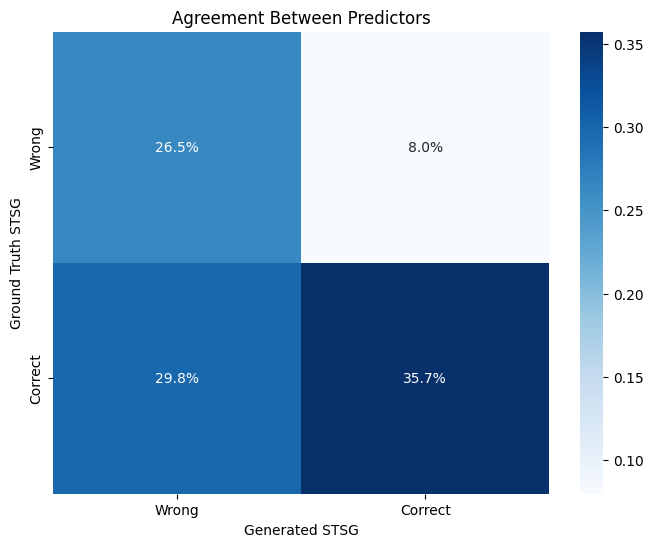

In [158]:
gt_stsg_correct = (eval_df['text'] == eval_df['pred_gt_stsg']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['pred_gen_stsg']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct'], 
    yticklabels=['Wrong', 'Correct'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


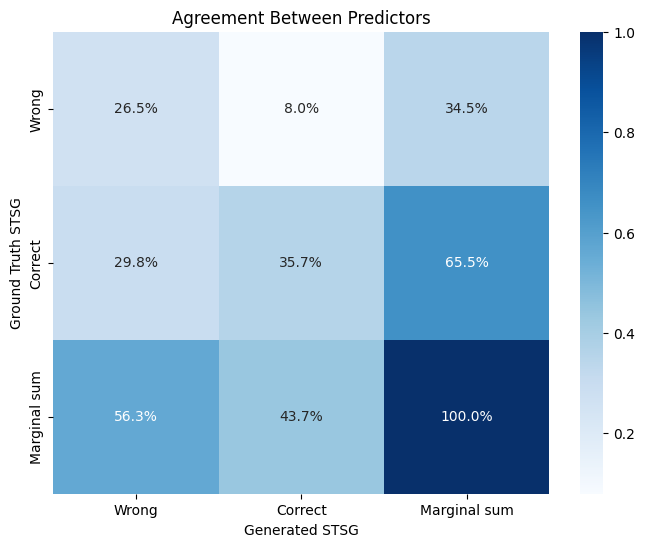

In [159]:
gt_stsg_correct = (eval_df['text'] == eval_df['pred_gt_stsg']).astype(int).values
gen_stsg_correct = (eval_df['text'] == eval_df['pred_gen_stsg']).astype(int).values

cm = confusion_matrix(gt_stsg_correct, gen_stsg_correct)
cm_norm = cm.astype('float') / cm.sum()

extended_matrix = np.zeros((cm.shape[0]+1,cm.shape[1]+1 ))
extended_matrix[:-1, :-1] = cm_norm
extended_matrix[:-1,-1] = cm_norm.sum(axis=1) # sum the rows (i.e. sum passing by columns a[0][i] for i...)
extended_matrix[-1,:-1] = cm_norm.sum(axis=0)
extended_matrix[-1, -1] = 1.0

plt.figure(figsize=(8, 6))
sns.heatmap(
    extended_matrix, annot=True, fmt='.1%', cmap='Blues',
    xticklabels=['Wrong', 'Correct', 'Marginal sum'], 
    yticklabels=['Wrong', 'Correct', 'Marginal sum'])

plt.xlabel('Generated STSG')
plt.ylabel('Ground Truth STSG')
plt.title('Agreement Between Predictors')
plt.show()


In [160]:
wrong_wrong_mask = (gt_stsg_correct == 0) & (gen_stsg_correct == 0)
wrong_wrong_df = eval_df[wrong_wrong_mask]

wrong_but_agree = (wrong_wrong_df['pred_gt_stsg'] == wrong_wrong_df['pred_gen_stsg']).astype(int)


In [161]:
# Ground truth (0 = different wrong predictions, 1 = same wrong prediction)
y_true = np.ones_like(wrong_but_agree)  # (Assuming we want to measure agreement)

# Since we're only checking agreement, we can just count matches vs mismatches
print("Sub-Confusion Matrix for Wrong-Wrong Cases:")
print(pd.crosstab(
    wrong_but_agree,
    columns=['Prediction Agreement'],
    rownames=['Same Wrong Prediction?']
))


Sub-Confusion Matrix for Wrong-Wrong Cases:
col_0                   Prediction Agreement
Same Wrong Prediction?                      
0                                        116
1                                        239


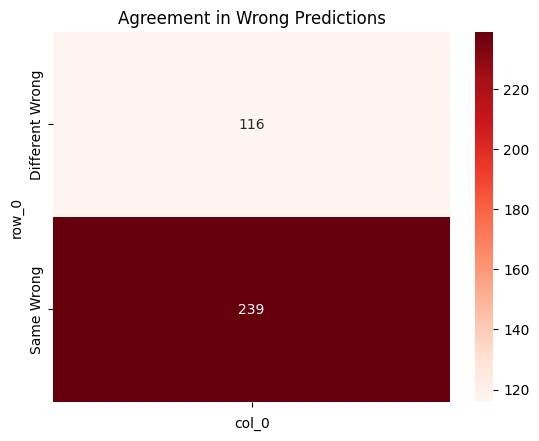

In [162]:
sns.heatmap(
    pd.crosstab(wrong_but_agree, columns=['']),
    annot=True, fmt='d', cmap='Reds',
    xticklabels=[''],
    yticklabels=['Different Wrong', 'Same Wrong']
)
plt.title('Agreement in Wrong Predictions')
plt.show()


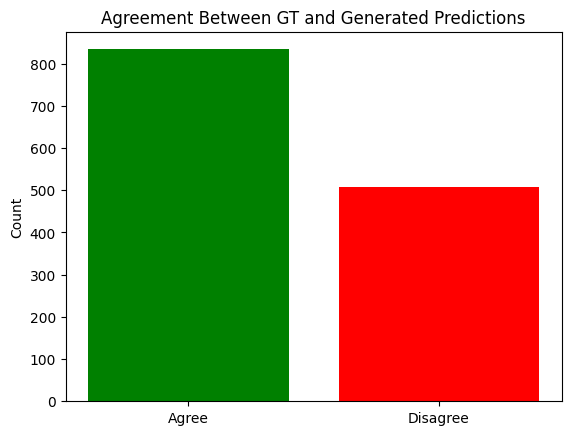

In [163]:
agreement = np.sum(gt_stsg_correct == gen_stsg_correct)
disagreement = len(gt_stsg_correct) - agreement

plt.bar(['Agree', 'Disagree'], [agreement, disagreement], color=['green', 'red'])
plt.title('Agreement Between GT and Generated Predictions')
plt.ylabel('Count')
plt.show()
